# Likelihood contourf with the FGD with the light minimal model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from Likelihood import LEff
from dark_nus_utils import load_datasets
from const import alphaQED
from parameters_dict import mass_material

0.0009866349020787781


In [32]:
hierarchy = 'light'
D_or_M = 'majorana'
distance = 'log'
smoothing_pars = (0.1, 0.1)
selection = 'carbon'
mass_ratio = 1848.6 * 1e-9 * 184**2  * 15 / mass_material[selection]
pot_ratio = 11.92/20

In [33]:
save_folder = f'../fig/6_visualization/{hierarchy}_{D_or_M}'
!mkdir -p $save_folder

In [34]:
levels = {0.68: -2.3/2,
          0.9: -4.61/2,
          0.95: -5.99/2}

In [35]:
my_exp_analysis = load_datasets(hierarchy, D_or_M, timeit=True, direct_load_objects=True)[f'{hierarchy}_{D_or_M}']

light majorana
Wall time: 53.9051558971405 s, CPU time: 2.5384091329999996


In [ ]:
my_exp_analysis.setResolutionEfficiency(smearing_p, smearing_theta, efficiency_p)

In [91]:
from ctau_utils import ctau_light
def light_simplified_posterior(m4=0.1, mz=0.03, Umu4_2=8e-9, Ud4_2=0.01, alpha_d=0.25, epsilon=2.1e-2, 
                               additional_factor=mass_ratio*pot_ratio, n_observed=0, n_predicted_sm=0):
    Vmu4_alpha_epsilon2 = alpha_d * Umu4_2 * alphaQED * epsilon**2
    Valpha4 = alpha_d * Ud4_2
    ctau = ctau_light(m4, 
                      mz, 
                      Valpha4, 
                      D_or_M)
    this_mu = Vmu4_alpha_epsilon2/my_exp_analysis.Vmu4_alpha_epsilon2
    mu, sigma2 = my_exp_analysis.kde_n_events(df=my_exp_analysis.df_base.query(selection),
                                                     m4mz=(m4, mz),
                                                     ctau=None,
                                                     mu=this_mu,
                                                     distance=distance,
                                                     smoothing=smoothing_pars)
    mu *= additional_factor
    sigma2 *= additional_factor**2
    return LEff(n_observed, n_predicted_sm+mu, sigma2), mu, sigma2, ctau

In [92]:
light_simplified_posterior_v = np.vectorize(light_simplified_posterior)

## Dark photon plots

In [93]:
# setting
m4_s = [0.1, 0.25, 0.42]
mz_for_grid = np.linspace(0.005, 0.095, 10)
epsilon_for_grid = np.geomspace(1e-5, 1e-1, 15)
mz, epsilon = np.meshgrid(mz_for_grid, epsilon_for_grid)

In [94]:
digitized_data = np.loadtxt('../digitized/nueCCQE_ND280_2020/FHC_invmass_data.dat')
digitized_data[:, 0] = np.linspace(0.005, 0.195, 20)
digitized_data[:, 1] = digitized_data[:, 1].astype(int)
digitized_data, epsilon = np.meshgrid(digitized_data[:, 1], epsilon_for_grid)
digitized_MCtot = np.loadtxt('../digitized/nueCCQE_ND280_2020/FHC_invmass_MCtot.dat')
digitized_MCtot[:, 0] = np.linspace(0.005, 0.195, 20)
digitized_MCtot, epsilon = np.meshgrid(digitized_MCtot[:, 1], epsilon_for_grid)

In [104]:
# calculation
dark_photons_constraints = {}
for m4 in m4_s:
    dark_photons_constraints[m4] = light_simplified_posterior_v(m4=m4, mz=mz, epsilon=epsilon[:, :10],
                                                                  n_observed=digitized_MCtot.astype(int)[:, :10], 
                                                                  n_predicted_sm=digitized_MCtot[:, :10])

Text(0.5, 1.0, 'BP-L2, constraint with perfect detector')

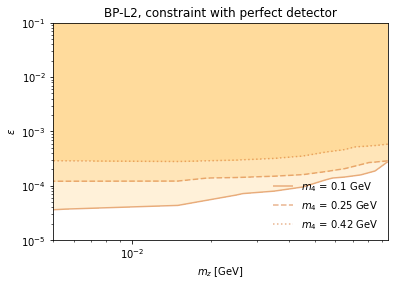

In [106]:
# plot
linestyles = ['-', '--', 'dotted']
contours = {}
for m4, linestyle in zip(m4_s, linestyles):
    plt.contourf(mz, epsilon[:, :10], dark_photons_constraints[m4][0], 
                                  levels=[-np.inf, dark_photons_constraints[m4][0].max() + levels[0.9]], 
                                colors=['orange'], alpha=0.15)
    contours[m4] = plt.contour(mz, epsilon[:, :10], dark_photons_constraints[m4][0], 
                                  levels=[-np.inf, dark_photons_constraints[m4][0].max() + levels[0.9]], 
                               colors=['chocolate'], linestyles=[linestyle], alpha=0.5)
plt.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
           [f'$m_4$ = {m4} GeV' for m4 in contours.keys()],
           frameon=False,
           loc='lower right')
plt.loglog()
plt.xlabel(r'$m_z$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.title('BP-L2, constraint with perfect detector')

<ipython-input-85-24cdf4c3a817>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = axs[0][0].pcolormesh(mz, epsilon, -dark_photons_constraints[m4][0], norm=LogNorm())
<ipython-input-85-24cdf4c3a817>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = axs[0][1].pcolormesh(mz, epsilon, dark_photons_constraints[m4][1], norm=LogNorm())
<ipython-input-85-24cdf4c3a817>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions a

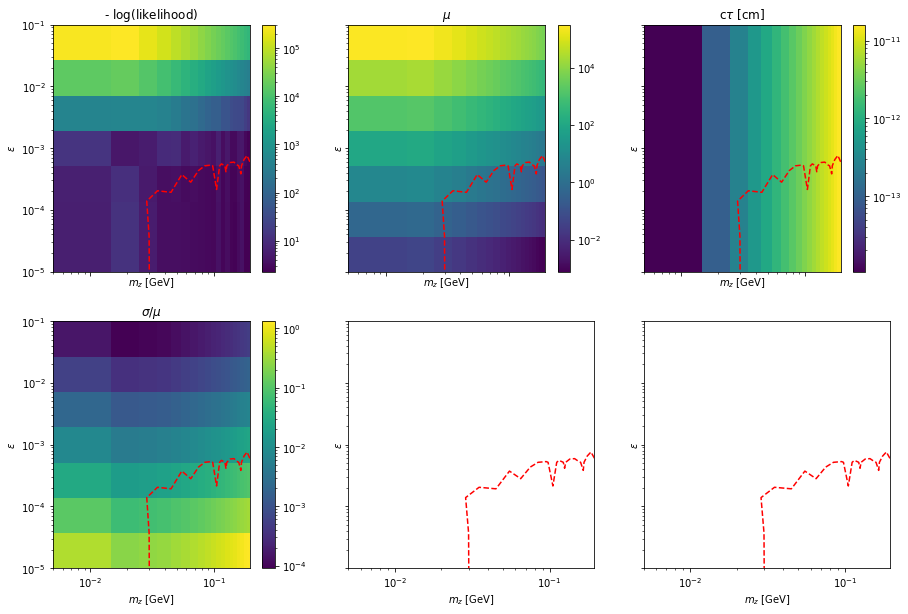

In [85]:
m4 = 0.42

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs[0][0].loglog()

pcm = axs[0][0].pcolormesh(mz, epsilon, -dark_photons_constraints[m4][0], norm=LogNorm())
fig.colorbar(pcm, ax=axs[0][0])
axs[0][0].set_title(r'- $\log$(likelihood)')

pcm = axs[0][1].pcolormesh(mz, epsilon, dark_photons_constraints[m4][1], norm=LogNorm())
fig.colorbar(pcm, ax=axs[0][1])
axs[0][1].set_title(r'$\mu$')

pcm = axs[0][2].pcolormesh(mz, epsilon, dark_photons_constraints[m4][3], norm=LogNorm())
fig.colorbar(pcm, ax=axs[0][2])
axs[0][2].set_title(r'c$\tau$ [cm]')

pcm = axs[1][0].pcolormesh(mz, epsilon, np.sqrt(dark_photons_constraints[m4][2])/dark_photons_constraints[m4][1], norm=LogNorm())
fig.colorbar(pcm, ax=axs[1][0])
axs[1][0].set_title(r'$\sigma / \mu$')

# pcm = axs[1][1].pcolormesh(mz, epsilon, dark_photons_constraints[m4][4], norm=LogNorm())
# fig.colorbar(pcm, ax=axs[1][1])
# axs[1][1].set_title(r'N passing c$\tau$')

# pcm = axs[1][2].pcolormesh(mz, epsilon, dark_photons_constraints[m4][5], norm=LogNorm())
# fig.colorbar(pcm, ax=axs[1][2])
# axs[1][2].set_title(r'N used for the KDE')

for axes in axs:
    for ax in axes:
        ax.set_xlabel(r'$m_z$ [GeV]')
        ax.set_ylabel(r'$\epsilon$')
        ax.contour(mz, epsilon, dark_photons_constraints[m4][0], 
                   levels=[dark_photons_constraints[m4][0].max() + levels[0.9]], colors=['red'])
        
fig.savefig(save_folder + 'dark_photon_space_study_precision.png', bbox_inches='tight', dpi=250)
fig.savefig(save_folder + 'dark_photon_space_study_precision.pdf')